In [1]:
import scipy as scp
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib widget

In [2]:
class Lattice:
    def __init__(self, *vecs):
        # if the vecs were put in an iterable
        if len(vecs) == 1:
            vecs = vecs[0]
        if len(vecs)  == 3:
            pass
        elif len(vecs) == 2:
            pass
        else: raise ValueError("Vecs must contain either 2 or 3 vectors")
        self.dim = len(vecs)
        self.vecs = list(vecs)
        for i, v in enumerate(self.vecs):
            if type(v) != np.ndarray:
                self.vecs[i] = np.array(v)
            if self.vecs[i].shape != (self.dim,):
                raise ValueError(f"Got {self.dim} vectors, therefore all vectors must be {self.dim} dimensional but vector {i+1} has shape {self.vecs[i].shape}")
        self.vecs = np.array(self.vecs)
        self.vec_lengths = np.array([np.linalg.norm(v) for v in self.vecs])
        self.center = np.zeros(self.dim)

    def get_point(self, *ns):
        if len(ns) != len(self.vecs): raise ValueError(f"Requires one index for each lattice vector {len(self.vecs)}, but got only {ns}")
        point = self.center.copy()
        for i, n in enumerate(ns):
            point += n * self.vecs[i]
        return point

    
    def get_points_around_center(self, n):
        points = []
        import itertools
        ns = [i for i in range(-n, n+1)]
        for n in itertools.product(*[ns for _ in range(self.dim)]):
            # print(n)
            points.append(self.get_point(*n))
        return points

In [3]:
def rot_mat_2D(rad):
    return np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])


def get_reciprocal_lattice(lattice: Lattice):
    if lattice.dim == 2:
        rot_90_deg = rot_mat_2D(np.pi / 2)
        a1, a2 = lattice.vecs
        b1 = 2 * np.pi * rot_90_deg @ a2 / (np.dot(a1, rot_90_deg @ a2))
        b2 = 2 * np.pi * rot_90_deg @ a1 / (np.dot(a2, rot_90_deg @ a1))
        return Lattice(b1, b2)
    elif lattice.dim == 3:
        a1, a2, a3 = lattice.vecs
        V = np.dot(a1, np.cross(a2, a3))
        b1 = 2 * np.pi/V * np.cross(a2, a3)
        b2 = 2 * np.pi/V * np.cross(a3, a1)
        b3 = 2 * np.pi/V * np.cross(a1, a2)
        return Lattice(b1, b2, b3)
    else: raise NotImplementedError(f"Dim must be 2 or 3, but is {lattice.dim}")

In [4]:

def get_elementary_cell(lattice: Lattice):
    points = lattice.get_points_around_center(1)
    return points

def get_orthogonal_2D(vec):
    return np.array((vec[1], -vec[0]))

def get_unit_cell_vertices(lattice: Lattice, voronoi: Voronoi):
    """regard only voronoi vertices which are closest to the center <=> their norm is <= 0.5*(norm of the unit vectors added together
    """
    lattice_vec_norm = np.sqrt(np.sum(lattice.vec_lengths**2))
    return voronoi.vertices[np.linalg.norm(voronoi.vertices, axis=1) <= 0.5 * lattice_vec_norm]
    
def plot_unit_cell(lattice, fig_ax=None, vec_label="a", subplot_kw={}):
    # get voronoi of the points around the center
    points = get_elementary_cell(lattice)
    voronoi = Voronoi(points)

    if fig_ax:
        fig, ax = fig_ax
    else:
        if lattice.dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1, projection="3d") 
        else:
            fig, ax = plt.subplots(**subplot_kw) 

    # unit cell vertices
    cell_points = get_unit_cell_vertices(lattice, voronoi)
    # sort by polar angle for the fill function
    cell_points = list(cell_points)
    # print(cell_points)
    # print([i for i in map(lambda p: np.arctan2(p[1],p[0]), cell_points)])
    if lattice.dim == 2:
        cell_points.sort(key=lambda p: np.arctan2(p[1],p[0]))
        x_cell, y_cell = zip(*cell_points)
        ax.fill(x_cell, y_cell, color="#4444")
        ax.scatter(x_cell, y_cell, color="orange")
    
        # lattice points
        x_lat, y_lat = zip(*lattice.get_points_around_center(3))
        ax.scatter(x_lat, y_lat, color="blue")
    
        # lattice vectors
        arrowprops = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8", color="black", shrinkA=0,shrinkB=0)
        for i, vec in enumerate(lattice.vecs):
            ax.annotate(f"", xy=lattice.vecs[i], xytext=lattice.center, arrowprops=arrowprops)
            if vec_label is not None:
                # add name of vector at a perpendicular offset starting at half length
                ax.annotate(r"$\vec{"+f"{vec_label}}}_{i+1}$", xy=0.7*lattice.vecs[i], xytext=0.7*lattice.vecs[i] + 0.06*get_orthogonal_2D(lattice.vecs[i]))
    elif lattice.dim == 3:
        # todo filter so that only
        ridges = voronoi.ridge_vertices
        lattice_vec_norm = np.sqrt(np.sum(lattice.vec_lengths**2))
        for ridge in ridges:
            # ATOMS
            verts = voronoi.vertices[ridge]
            # TODO: doesnt seem to work
            """regard only voronoi vertices which are closest to the center <=> their norm is <= 0.5*(norm of the unit vectors added together
                """
            verts = verts[np.linalg.norm(verts, axis=1) <= 0.5 * lattice_vec_norm]
            x_lat, y_lat, z_lat = zip(*lattice.get_points_around_center(1))
            ax.scatter(x_lat, y_lat, z_lat, color="red", marker=".")
            # print(verts, type(verts), verts.shape, verts.ndim)
            ax.add_collection3d(Poly3DCollection([voronoi.vertices[ridge]], edgecolor="black", alpha=0.5))
            # UNIT VECTORS 
            for vec in lattice.vecs:
                ax.plot(*[i for i in zip([0,0,0], vec)])
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_zlim(-2, 2)
            
    else: raise NotImplementedError(f"Dim must be 2 or 3, but is {lattice.dim}")

    # limit to 2*lattice vectors
    def calc_lim(axis):
        lim = 2.05 * np.max(np.abs(lattice.vecs[axis,:]))
        return -lim, lim
    ax.set_xlim(*calc_lim(0))
    ax.set_ylim(*calc_lim(1))
    if lattice.dim == 3: ax.set_zlim(*calc_lim(2))
    fig.tight_layout()
    return fig

In [5]:
sphere_point = lambda rad: np.array([np.cos(rad), np.sin(rad)])

square_lattice = Lattice([1, 0], [0, 1])
tilted_lattice = Lattice([1, 0.5], [0, 1])
honeycomb_lattice = Lattice(sphere_point(0), sphere_point(np.pi * 2/3))

In [6]:
# fig, axs = plt.subplots(3, figsize=(4, 12))
# plot_unit_cell(square_lattice, fig_ax=(fig, axs[0]))
# plot_unit_cell(tilted_lattice, fig_ax=(fig, axs[1]))
# plot_unit_cell(honeycomb_lattice, fig_ax=(fig,axs[2]));

In [7]:
def plot_lattice(lattice: Lattice):
    reci = get_reciprocal_lattice(lattice)
    print(reci.vecs)
    if lattice.dim == 3:
        fig = plt.figure()
        axs = [fig.add_subplot(1,2,i, projection="3d") for i in [1,2]]
        fig.suptitle("3D Lattice")
        
    else:
        fig, axs = plt.subplots(1, 2)
    plot_unit_cell(lattice, fig_ax=(fig, axs[0]))
    plot_unit_cell(reci, fig_ax=(fig, axs[1]), vec_label="b")

[[ 6.28318531e+00 -3.84734139e-16]
 [ 3.84734139e-16  6.28318531e+00]]
[[ 6.28318531e+00 -3.84734139e-16]
 [-3.14159265e+00  6.28318531e+00]]
[[6.28318531e+00 3.62759873e+00]
 [4.44252717e-16 7.25519746e+00]]


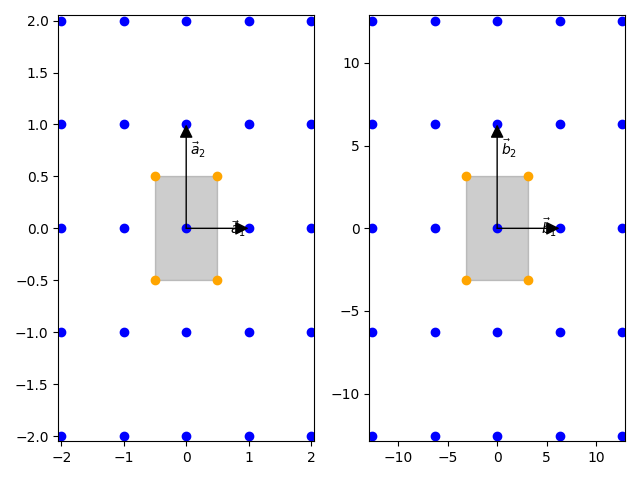

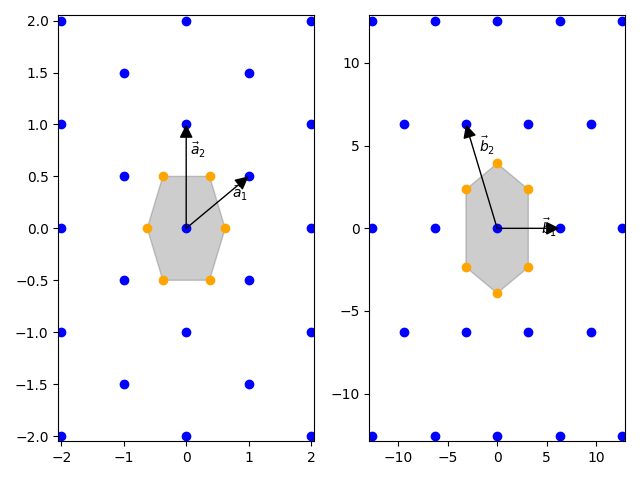

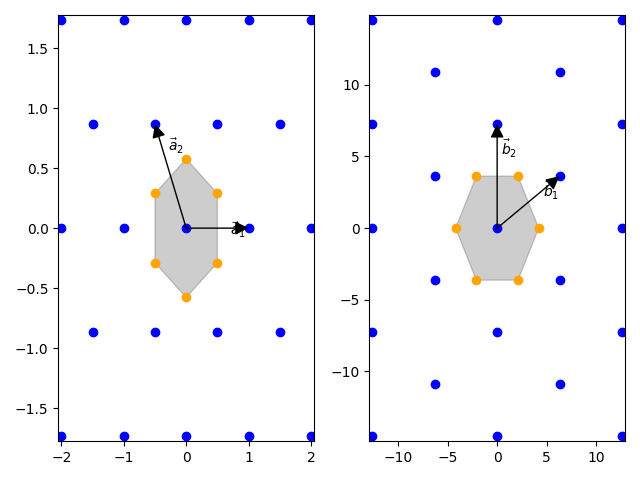

In [8]:
plot_lattice(square_lattice)
plot_lattice(tilted_lattice)
plot_lattice(honeycomb_lattice)

In [9]:
simple_cubic = Lattice([1,0,0], [0,1,0], [0,0,1])
graphite = Lattice([0.5,-0.5 * 3**(0.5),0], [0.5,0.5 * 3**(0.5),0], [0,0,1])
fcc = Lattice([0.5,0.5,-0.5], [-0.5,0.5,0.5], [0.5,-0.5,0.5])


[[6.28318531 0.         0.        ]
 [0.         6.28318531 0.        ]
 [0.         0.         6.28318531]]
[[ 6.28318531 -3.62759873  0.        ]
 [ 6.28318531  3.62759873 -0.        ]
 [-0.          0.          6.28318531]]
[[6.28318531 6.28318531 0.        ]
 [0.         6.28318531 6.28318531]
 [6.28318531 0.         6.28318531]]


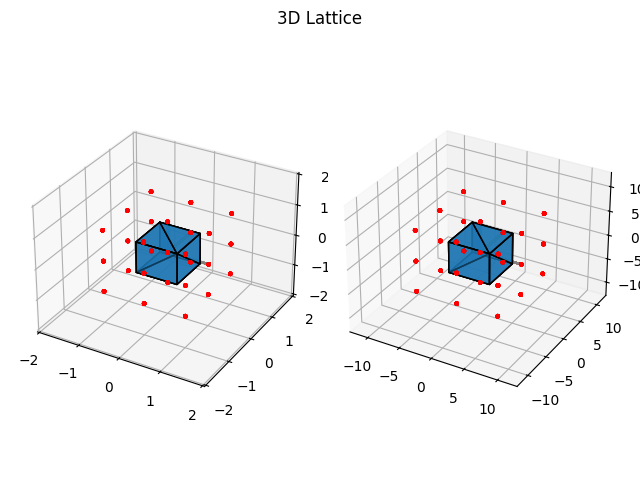

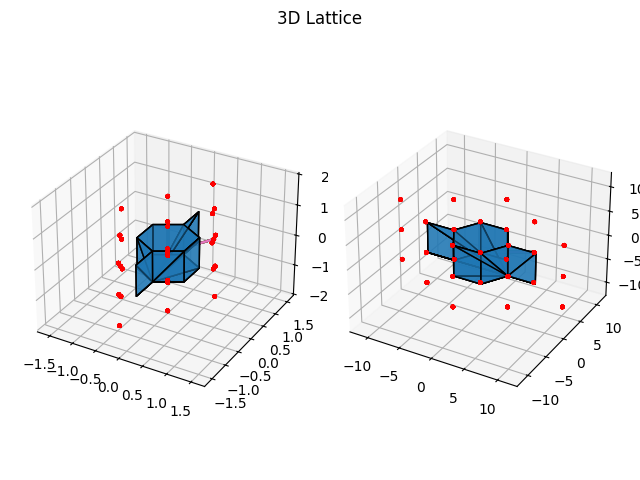

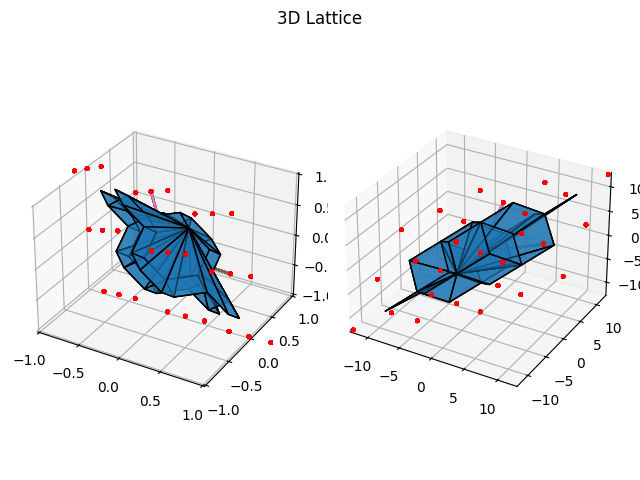

In [10]:
plot_lattice(simple_cubic);
plot_lattice(graphite);
plot_lattice(fcc);

Text(0.5, 0.92, '3D Lettuce')

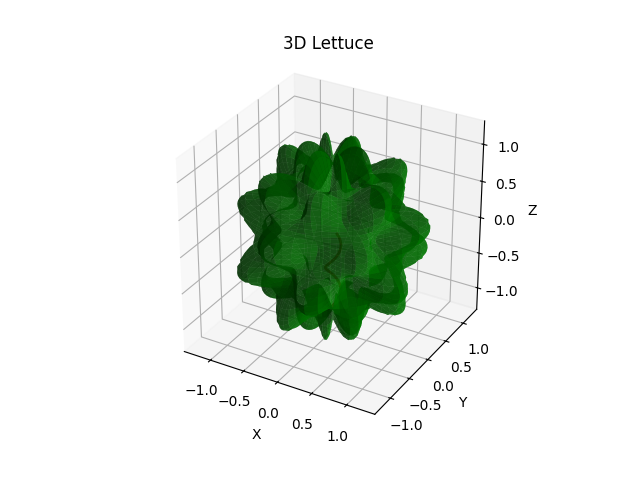

In [11]:
# Function to create the lettuce shape
def lettuce_leaf(u, v):
    r = 1 + 0.3 * np.sin(6 * u) * np.sin(6 * v)
    x = r * np.cos(u) * np.sin(v)
    y = r * np.sin(u) * np.sin(v)
    z = r * np.cos(v)
    return x, y, z

# Function to create the root
def root(t):
    x = 0.1 * np.sin(10 * t)
    y = 0.1 * np.cos(10 * t)
    z = -t
    return x, y, z

# Generate the lettuce surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
u, v = np.meshgrid(u, v)
x, y, z = lettuce_leaf(u, v)

# Generate the root
t = np.linspace(0, 1, 100)
x_root, y_root, z_root = root(t)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the lettuce
ax.plot_surface(x, y, z, color='green', alpha=0.7)

# Plot the root
ax.plot(x_root, y_root, z_root, color='brown', linewidth=2)

# Adjust plot
ax.set_box_aspect([1,1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Lettuce')
